In [1]:
from pathlib import Path
import re

import scope
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", font_scale=1.3, palette="Paired")
plt.rcParams['figure.dpi'] = 300

In [34]:
def _read_float_file(path: Path, cutoff=200, min_length=None):
    reader = scope.Reader(path)
    steps, episode_scores = reader['episode/score']
    if min_length is not None:
        actual_steps = [steps[i] - (steps[i-1] if i > 0 else 0) for i in range(len(steps))]
        episode_scores = [score for i, score in enumerate(episode_scores) if actual_steps[i] >= min_length]
    
    if len(episode_scores) < cutoff:
        print(f"Warning: {path} has only {len(episode_scores)} episodes, less than the cutoff of {cutoff}.")
    return np.asarray(episode_scores)[:cutoff]

def plot_maniskill(files_labels=[], output=None):
    plt.figure(figsize=(10, 6))

    bars = []
    labels = []
    hue = []
    for path, label in files_labels:
        bars.append(_read_float_file(Path(path)).mean())
        *name, dist = label.split(" ")
        labels.append(" ".join(name))
        hue.append(dist)

    g = sns.catplot(
        kind="bar", x=labels, y=bars, hue=hue,
        errorbar="sd", palette="Set2", alpha=.8, height=6
    )
    g.despine(left=True)

    plt.xlabel("Environment Setting")
    plt.ylabel("Average Reward")
    plt.title(f"Average reward over 200 episodes")
    # plt.tight_layout()
    if output:
        plt.savefig(output, dpi=300)
        print(f"Saved figure → {output}")
    print(list(zip(labels, bars, hue)))

def plot_carla(files_labels=[], output=None):
    plt.figure(figsize=(10, 6))

    bars = []
    labels = []
    hue = []
    for path, label in files_labels:
        bars.append(_read_float_file(Path(path), cutoff=50, min_length=20).mean())
        *name, dist = label.split(" ")
        labels.append(" ".join(name))
        hue.append(dist)

    g = sns.catplot(
        kind="bar", x=labels, y=bars, hue=hue,
        errorbar="sd", palette="Set2", alpha=.8, height=6
    )
    g.despine(left=True)

    plt.xlabel("Environment Setting")
    plt.ylabel("Average Reward")
    plt.title(f"Average reward over 200 episodes")
    # plt.tight_layout()
    if output:
        plt.savefig(output, dpi=300)
        print(f"Saved figure → {output}")
    print(list(zip(labels, bars, hue)))

[('Baseline', 10.91115521316242, 'ID'), ('Baseline', 10.548903430586797, 'OOD'), ('DINO finetune', 10.886660591497861, 'ID'), ('DINO finetune', 10.163853350208697, 'OOD'), ('DINO Partial', 9.802362432804657, 'ID'), ('DINO Partial', 9.4049647959051, 'OOD'), ('DINO frozen', 9.37123670268617, 'ID'), ('DINO frozen', 8.77676312987227, 'OOD')]


<Figure size 3000x1800 with 0 Axes>

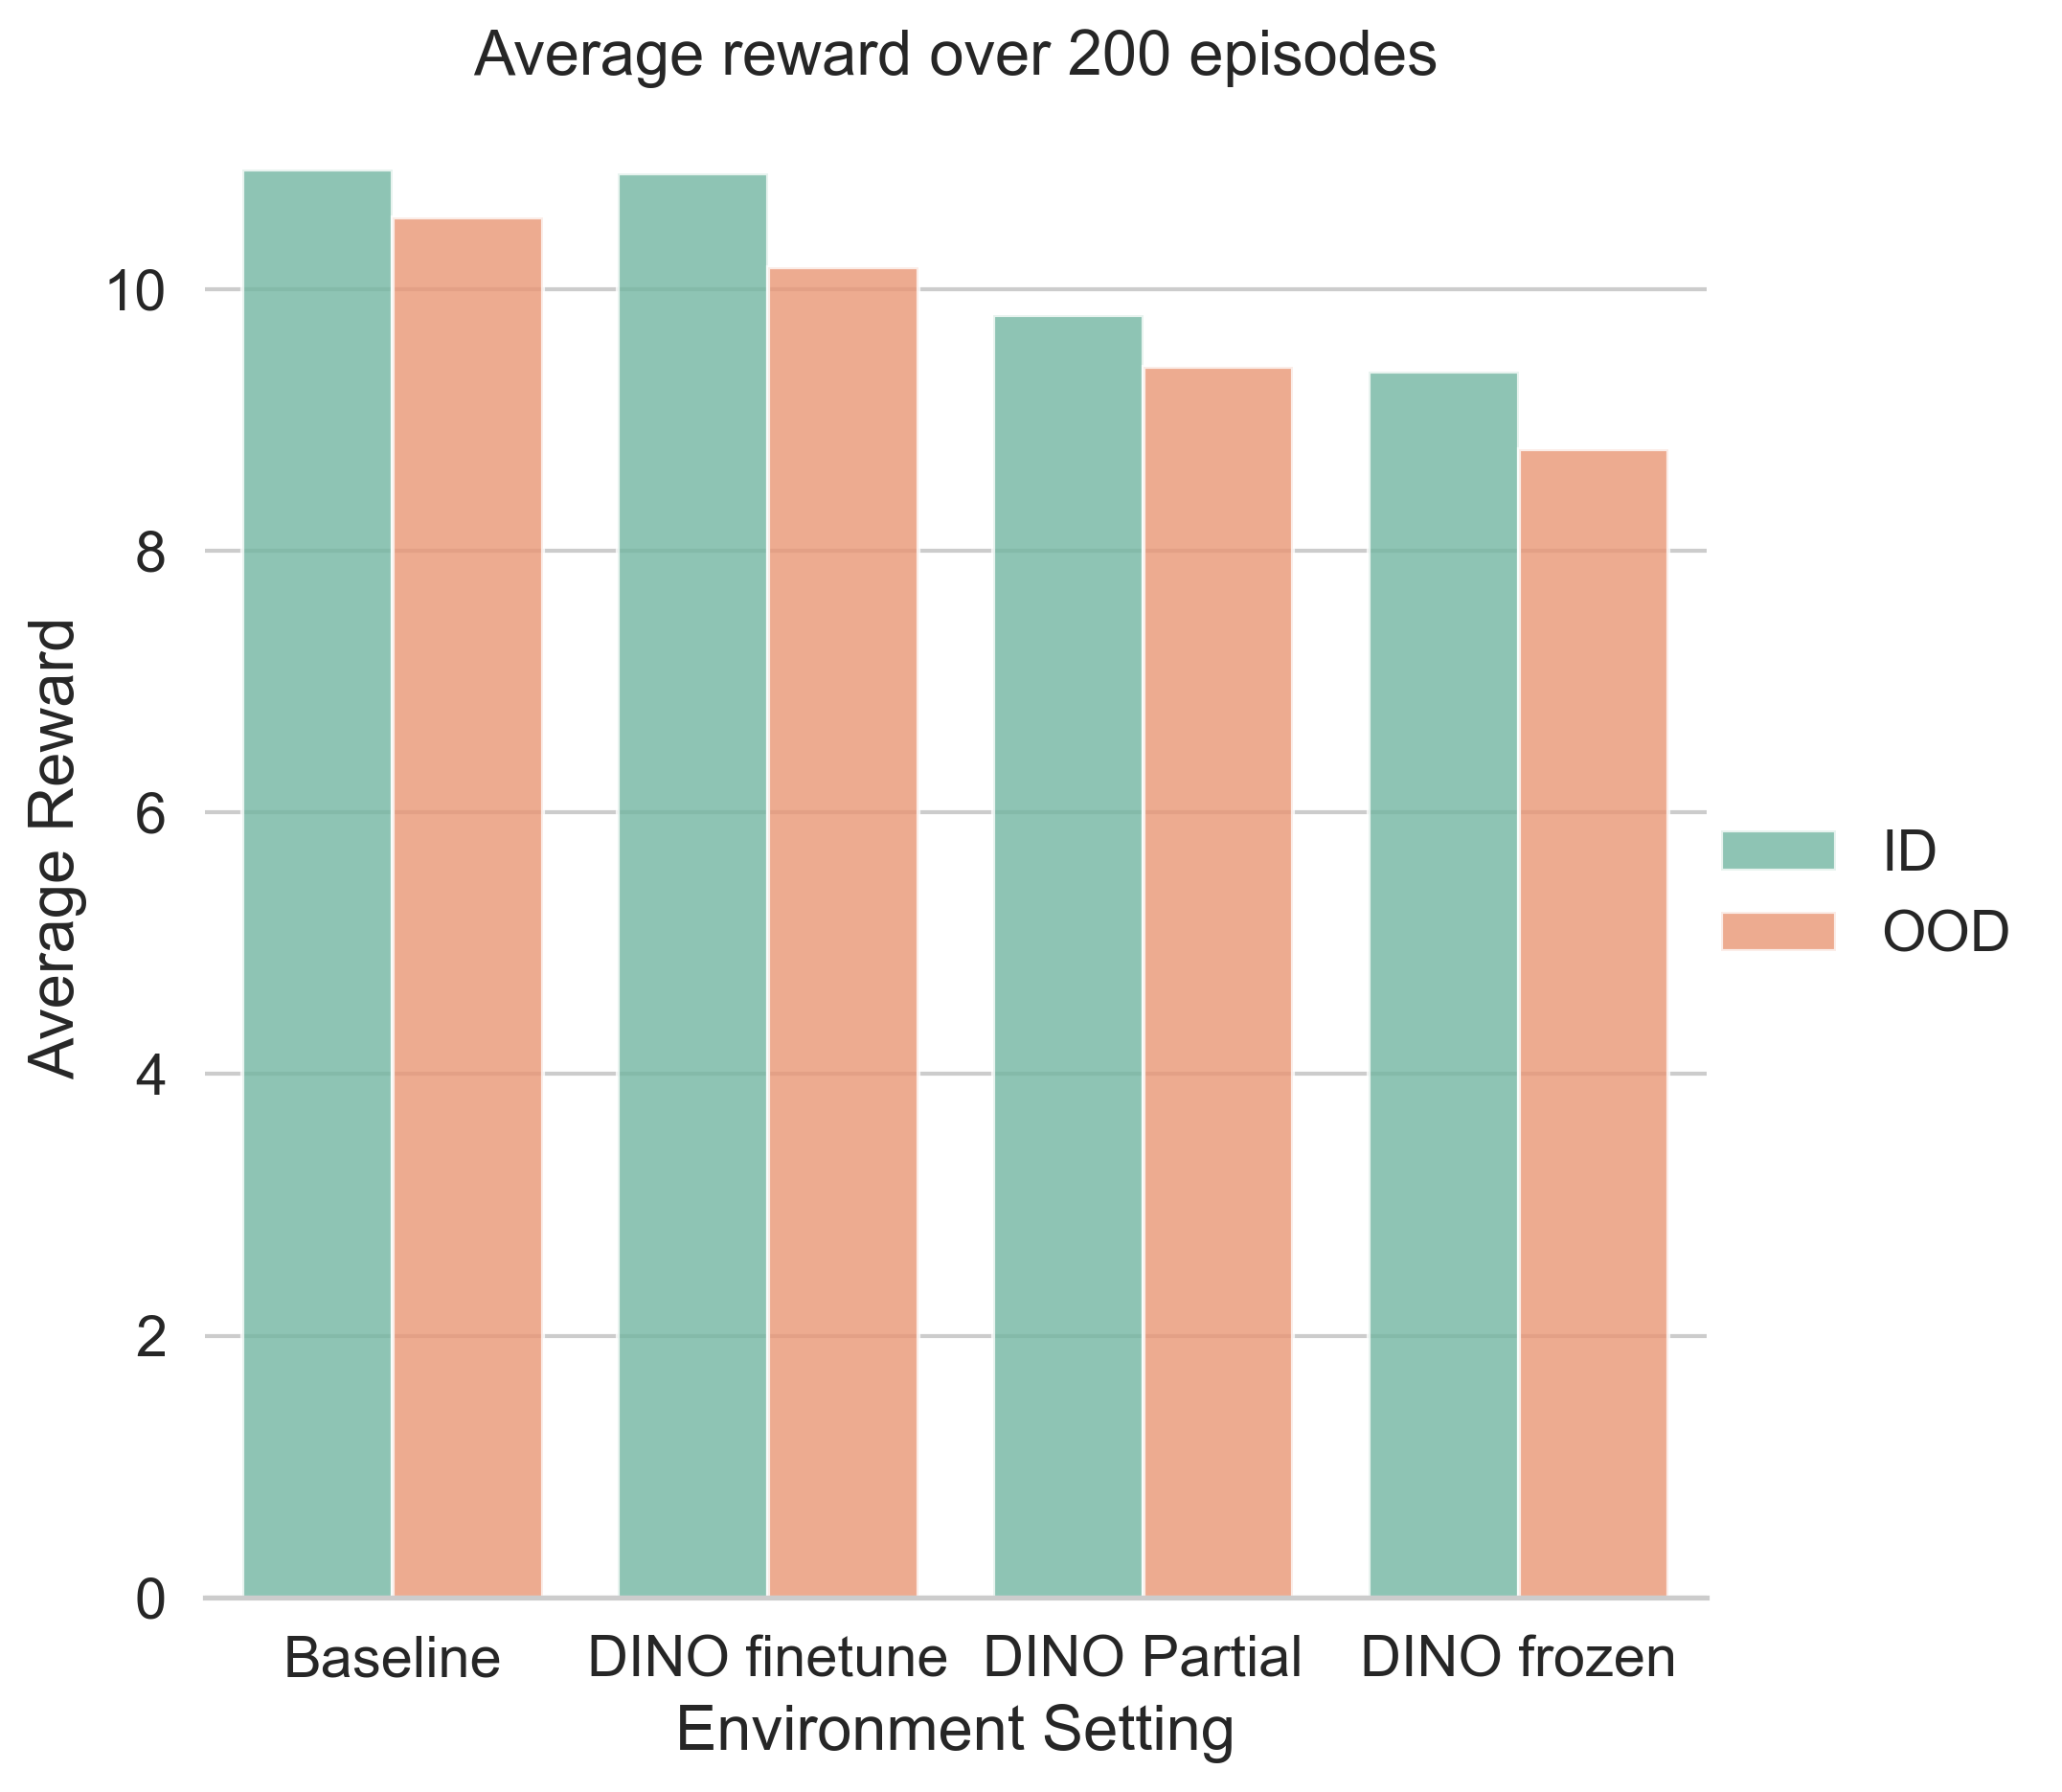

In [35]:
plot_maniskill(
    files_labels=[
        ("logdir/baseline_pick_ycb_eval_ID/", "Baseline ID"),
        ("logdir/baseline_pick_ycb_eval_OOD/", "Baseline OOD"),
        ("logdir/DINOFT_pick_ycb_eval_ID/", "DINO finetune ID"),
        ("logdir/DINOFT_pick_ycb_eval_OOD/", "DINO finetune OOD"),
        ("logdir/DINOPartial_pick_ycb_eval_ID/", "DINO Partial ID"),
        ("logdir/DINOPartial_pick_ycb_eval_OOD/", "DINO Partial OOD"),
        ("logdir/DINOFreeze_pick_ycb_eval_ID/", "DINO frozen ID"),
        ("logdir/DINOFreeze_pick_ycb_eval_OOD/", "DINO frozen OOD"),
    ]
)

[('Baseline', 23.061779835543184, 'softhighlight'), ('DINO finetune', 144.57957336153063, 'softhighlight'), ('DINO frozen', 117.92635806444748, 'softhighlight'), ('Baseline', 96.51773203923949, 'softnoisylowlight'), ('DINO finetune', 74.64907516029896, 'softnoisylowlight'), ('DINO frozen', 131.00678959619952, 'softnoisylowlight'), ('Baseline', -7.233048234864655, 'hardlowlight'), ('DINO finetune', 42.10350622469326, 'hardlowlight'), ('DINO frozen', 87.83540980678518, 'hardlowlight'), ('Baseline', -10.311884176575695, 'hardnoisylowlight'), ('DINO finetune', -6.906808357569389, 'hardnoisylowlight'), ('DINO frozen', 108.12376404464906, 'hardnoisylowlight')]


<Figure size 3000x1800 with 0 Axes>

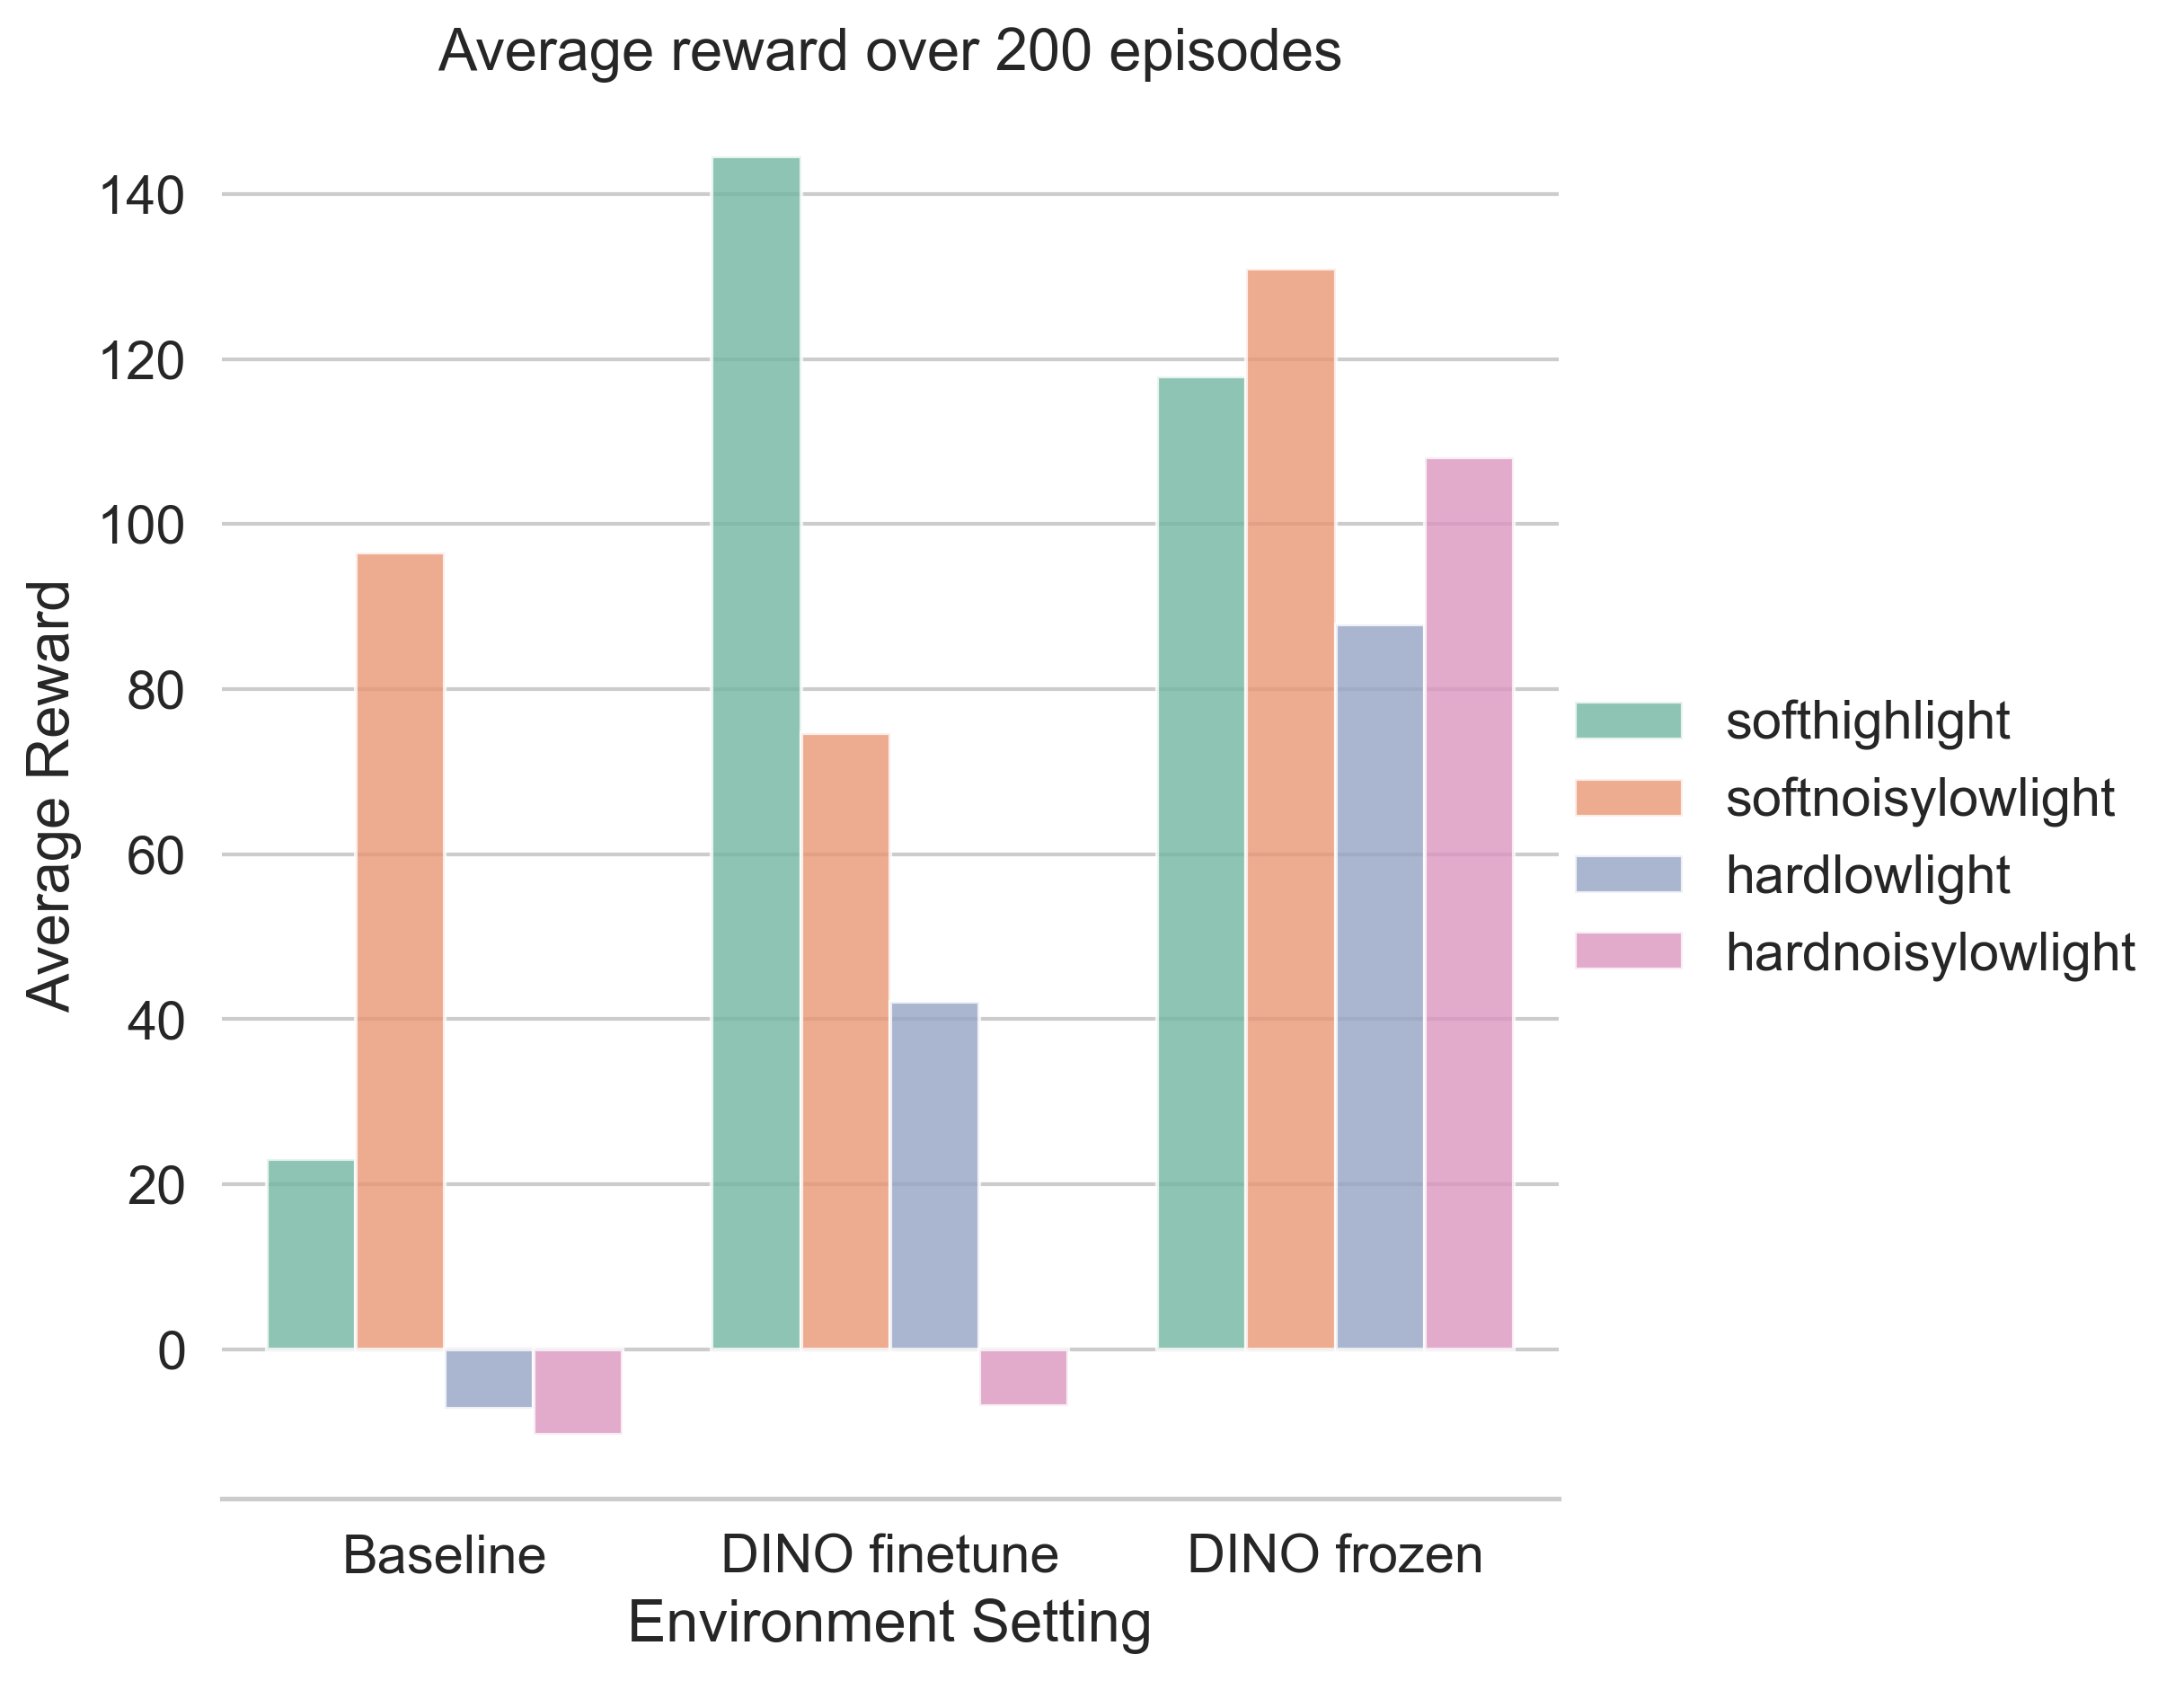

In [39]:
plot_carla(
    files_labels=[
        ("logdir/baseline_carla_eval_soft_high_light", "Baseline softhighlight"),
        ("logdir/DINOFT_carla_eval_soft_high_light", "DINO finetune softhighlight"),
        ("logdir/DINOFreeze_carla_eval_soft_high_light", "DINO frozen softhighlight"),
        ("logdir/baseline_carla_eval_soft_noisy_low_light", "Baseline softnoisylowlight"),
        ("logdir/DINOFT_carla_eval_soft_noisy_low_light", "DINO finetune softnoisylowlight"),
        ("logdir/DINOFreeze_carla_eval_soft_noisy_low_light", "DINO frozen softnoisylowlight"),

        ("logdir/baseline_carla_eval_hard_low_light", "Baseline hardlowlight"),
        ("logdir/DINOFT_carla_eval_hard_low_light", "DINO finetune hardlowlight"),
        ("logdir/DINOFreeze_carla_eval_hard_low_light", "DINO frozen hardlowlight"),
        ("logdir/baseline_carla_eval_hard_noisy_low_light", "Baseline hardnoisylowlight"),
        ("logdir/DINOFT_carla_eval_hard_noisy_low_light", "DINO finetune hardnoisylowlight"),
        ("logdir/DINOFreeze_carla_eval_hard_noisy_low_light", "DINO frozen hardnoisylowlight"),
    ]
)

## Catastrophic Forgetting
In this experiment we train a K-Nearest Neighbours model on the output representation from the DinoV2 models before and after end-to-end finetuning with DreamerV3. In this small diagnostic test we trained using a 80:20 split from 20k ImageNet images.

/var/folders/sz/_6t9n1rn6b7bxg8p0wzyw0g00000gn/T/ipykernel_3562/1506220593.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=imagenet_knn_accuracy, x=imagenet_knn_labels, palette="Set2", width=0.5, alpha=0.8)


<Axes: title={'center': 'Catastrophic Forgetting: ImageNet KNN Accuracy'}, xlabel='Model Type', ylabel='Test Accuracy (%)'>

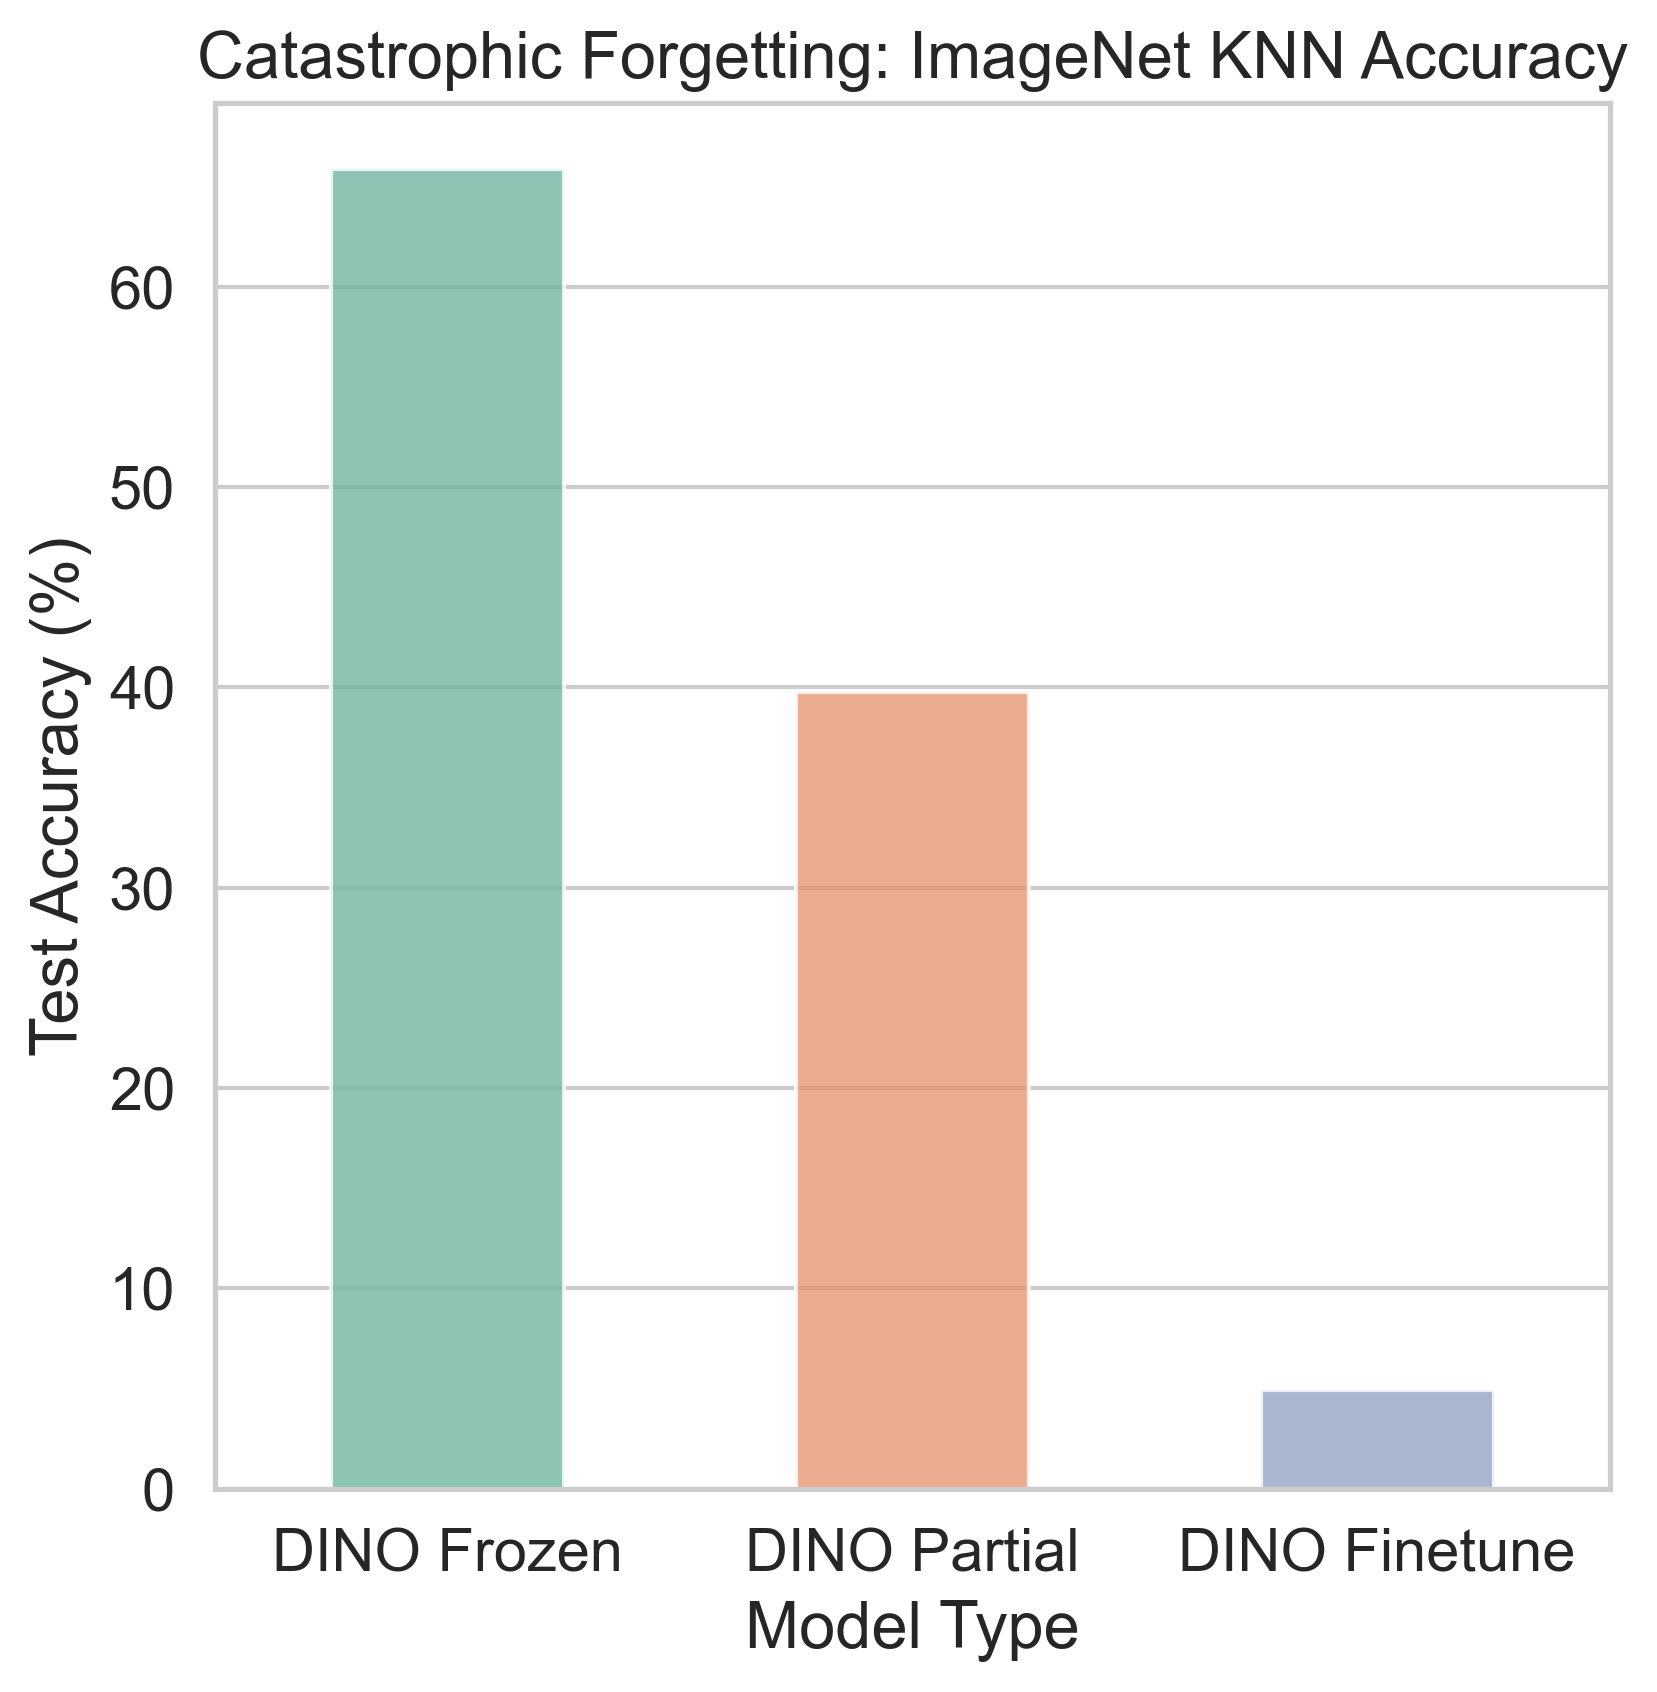

In [13]:
imagenet_knn_accuracy = [65.88, 39.77, 4.92]
imagenet_knn_labels = ["DINO Frozen", "DINO Partial", "DINO Finetune"]
plt.figure(figsize=(6, 6))
plt.xlabel("Model Type")
plt.ylabel("Test Accuracy (%)")
plt.title(f"Catastrophic Forgetting: ImageNet KNN Accuracy")
sns.barplot(y=imagenet_knn_accuracy, x=imagenet_knn_labels, palette="Set2", width=0.5, alpha=0.8)